# Going Deeper 2 
# 프로젝트: ResNet Ablation Study

**\# 평가 루브릭**
1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?  
블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.


2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?  
cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.


3. Ablation Study 결과가 바른 포맷으로 제출되었는가?  
ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

---

# 0) 라이브러리 버전 확인하기

In [ ]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


# 1) ResNet 기본 블록 구성하기

![image](https://user-images.githubusercontent.com/97072815/158722711-017d9f7f-af06-486a-b30f-2fe1cecaa6a9.png) <img src="https://github.com/raghakot/keras-resnet/raw/master/images/residual_block.png?raw=trueg" width="20%" height="20%"/>

필요한 모듈 import

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.layers import (Input, Activation, Dense, Flatten, BatchNormalization)
from keras.layers.convolutional import (Conv2D, MaxPooling2D, AveragePooling2D)
from keras.layers.merge import add
from keras.layers.pooling import GlobalAveragePooling2D

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

기본 블럭을 정의합니다.  
추가 논문에서 제안했던 구조대로 컨벌루션 레이어 앞에 Batch normalization과 ReLU를 순차적으로 수행합니다.

In [ ]:
def conv_block(input_layer, filters, kernel_size, strides=1, name='None'):
  conv_name = 'conv_' + str(name)
  batch_name = 'batch_' + str(name)
  act_name = 'act_' + str(name) # 구분을 위해 네이밍하는 부분

  x = BatchNormalization(name=batch_name)(input_layer)
  x = Activation(activation="relu", name=act_name)(x)

  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', name=conv_name)(x)
  return x

Residual 블럭을 정의합니다.  
위에서 정의한 conv 블럭을 쌓아서 하나의 블럭으로 만듭니다.
ResNet-34는 한 블럭에 2개의 conv 레이어를 가지고,  
ResNet-50은 한 블럭에 3개의 conv 레이어를 가집니다.

In [ ]:
def residual_block(input_layer, filters = 64, is_50 = False, channel_list=[3, 4, 6, 3]):
  x = input_layer
# shortcut은 이전 입력을 그대로 전해주는 역할을 합니다.
  if not is_50: # ResNet-34
    for i, ch_list in enumerate(channel_list):
      for ch in range(ch_list):
        if ch == 0 and i != 0: # 각 블럭의 첫 번째는 이전 입력을 받아 크기를 반으로 줄여줍니다. 단, 가장 첫 블럭은 크기를 줄이지 않습니다.
          shortcut = conv_block(input_layer=x, filters=filters, kernel_size=1, strides=2, name=f'make_shortcut_{i}_{ch}') # 입력을 그대로 전달하기 위해 크기를 맞춰줍니다.
          x = conv_block(input_layer=x, filters=filters, kernel_size=3, strides=2, name=f'{i}_{ch}_0')
          x = conv_block(input_layer=x, filters=filters, kernel_size=3, strides=1, name=f'{i}_{ch}_1')        
        else:
          shortcut = x # 이전 입력을 그대로 받아옵니다.
          x = conv_block(input_layer=x, filters=filters, kernel_size=3, strides=1, name=f'{i}_{ch}_0')
          x = conv_block(input_layer=x, filters=filters, kernel_size=3, strides=1, name=f'{i}_{ch}_1')
        x = add(inputs=[shortcut, x], name=f'addition_{i}_{ch}') # 두 번의 conv 레이어를 통과한 값과 이전 입력값을 더해줍니다.
      filters *= 2 # 같은 채널수를 가진 블럭을 모두 거치고 나면 필터수(채널수)를 두배로 높여줍니다.

  else: # ResNet-50
    for i, ch_list in enumerate(channel_list):
      for ch in range(ch_list):
        if ch == 0 and i == 0: # 가장 첫 블럭은 크기를 줄이지 않고, 이전 입력의 필터수(채널수)만 맞춰줍니다.
          shortcut = conv_block(input_layer=x, filters=filters*4, kernel_size=1, strides=1, name=f'make_shortcut_{i}_{ch}')
          x = conv_block(input_layer=x, filters=filters, kernel_size=1, strides=1, name=f'{i}_{ch}_0')
          x = conv_block(input_layer=x, filters=filters, kernel_size=3, strides=1, name=f'{i}_{ch}_1')
          x = conv_block(input_layer=x, filters=filters*4, kernel_size=1, strides=1, name=f'{i}_{ch}_2')
        elif ch == 0 and i != 0: # 가장 첫 블럭을 제외한 각 블럭의 첫 번째는 shortcut의 필터수와 크기를 모두 맞춰줍니다.
          shortcut = conv_block(input_layer=x, filters=filters*4, kernel_size=1, strides=2, name=f'make_shortcut_{i}_{ch}')
          x = conv_block(input_layer=x, filters=filters, kernel_size=1, strides=2, name=f'{i}_{ch}_0')
          x = conv_block(input_layer=x, filters=filters, kernel_size=3, strides=1, name=f'{i}_{ch}_1')
          x = conv_block(input_layer=x, filters=filters*4, kernel_size=1, strides=1, name=f'{i}_{ch}_2')
        else:
          shortcut = x
          x = conv_block(input_layer=x, filters=filters, kernel_size=1, strides=1, name=f'{i}_{ch}_0')
          x = conv_block(input_layer=x, filters=filters, kernel_size=3, strides=1, name=f'{i}_{ch}_1')
          x = conv_block(input_layer=x, filters=filters*4, kernel_size=1, strides=1, name=f'{i}_{ch}_2')
        x = add(inputs=[shortcut, x], name=f'addition_{i}_{ch}')      
      filters *= 2

  return x

위에서 작성한 Residual 블럭을 이용해서 전체 ResNet을 정의해줍니다.  
논문에서 얘기한대로 Global Average Pooling을 사용했습니다.  
여기서는 cat vs dog 데이터를 사용했으므로,  
마지막 레이어가 1개의 값을 가지며 활성화 함수로 sigmoid를 거칩니다.  
다른 데이터의 경우 알맞는 클래스 수가 출력 채널수가 되며, softmax 함수를 거칩니다.

In [ ]:
def build_resnet(input_shape=(224, 224, 3), is_50=False, num_classes=1000, catdog=False):
  input_layer = keras.layers.Input(shape=input_shape, name='input')

  x = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', name='conv_first')(input_layer)
  x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same', name='pool_first')(x)

  x = residual_block(input_layer=x, is_50=is_50)

  x = BatchNormalization(name='batch_last')(x)
  x = Activation(activation="relu", name='act_last')(x)

  #x = AveragePooling2D(strides = 1, padding='same', name='pooling')(x)
  #x = Flatten(name='flatten')(x)  
  x = GlobalAveragePooling2D(name='GAP')(x)

  if catdog:
    output_layer = Dense(units=1, activation='sigmoid', name='FC-1000')(x)
  else:
    output_layer = Dense(units=num_classes, activation='softmax', name='FC-1000')(x)

  model = keras.Model(inputs=input_layer, outputs=output_layer)
  return model

# 2) ResNet-34, ResNet-50 Complete Model

**\# ResNet-34**

ResNet-34를 위에서 정의한 함수로 선언합니다.

In [ ]:
model_resnet_34 = build_resnet()
model_resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_first (Conv2D)            (None, 112, 112, 64  9472        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 pool_first (MaxPooling2D)      (None, 56, 56, 64)   0           ['conv_first[0][0]']             
                                                                                              

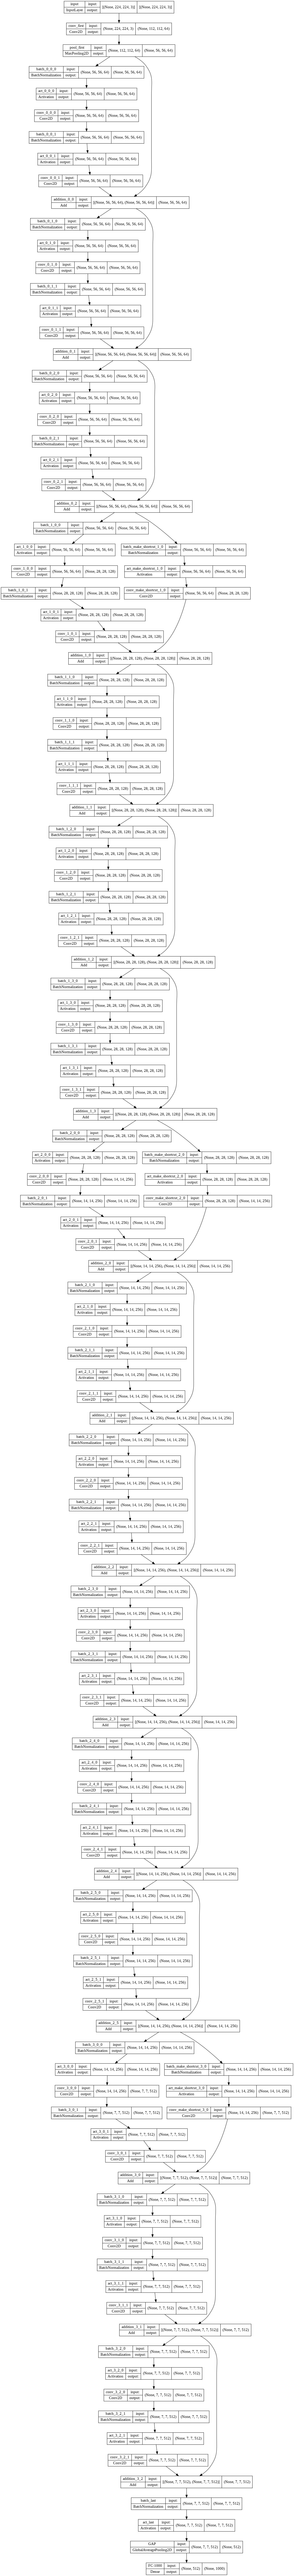

In [ ]:
keras.utils.plot_model(model_resnet_34, show_shapes=True)

\# ResNet-50

ResNet-50 또한 선언합니다.  
이 때, is_50 옵션을 True로 설정하여 생성하면 ResNet-34가 아닌 ResNet-50이 선언됩니다.

In [ ]:
model_resnet_50 = build_resnet(is_50=True)
model_resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_first (Conv2D)            (None, 112, 112, 64  9472        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 pool_first (MaxPooling2D)      (None, 56, 56, 64)   0           ['conv_first[0][0]']             
                                                                                            

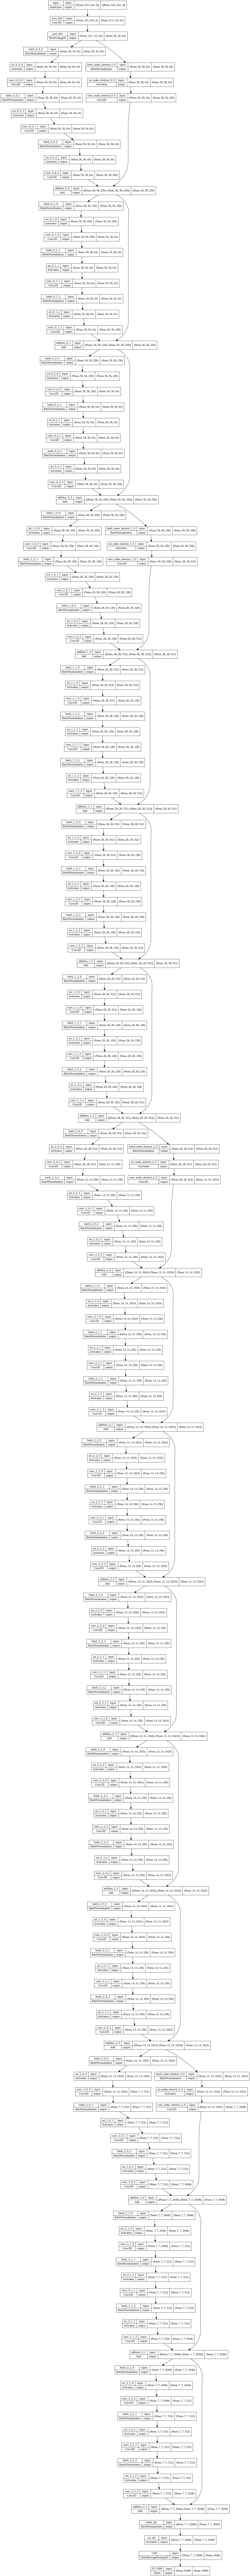

In [ ]:
keras.utils.plot_model(model_resnet_50, show_shapes=True)

# 3) 일반 네트워크(plain network) 만들기

\# 블록 코드 수정하기

Residual 블록 함수에서 skip connection을 담당하는 shortcut 부분을 제거합니다.

In [ ]:
def plain_block(input_layer, filters = 64, is_50 = False, channel_list=[3, 4, 6, 3]):
  x = input_layer

  if not is_50: # ResNet-34
    for i, ch_list in enumerate(channel_list):
      for ch in range(ch_list):
        if ch == 0 and i != 0:
          x = conv_block(input_layer=x, filters=filters, kernel_size=3, strides=2, name=f'{i}_{ch}_0')
          x = conv_block(input_layer=x, filters=filters, kernel_size=3, strides=1, name=f'{i}_{ch}_1')        
        else:
          x = conv_block(input_layer=x, filters=filters, kernel_size=3, strides=1, name=f'{i}_{ch}_0')
          x = conv_block(input_layer=x, filters=filters, kernel_size=3, strides=1, name=f'{i}_{ch}_1')
      filters *= 2

  else: # ResNet-50
    for i, ch_list in enumerate(channel_list):
      for ch in range(ch_list):
        if ch == 0 and i != 0:
          x = conv_block(input_layer=x, filters=filters, kernel_size=1, strides=2, name=f'{i}_{ch}_0')
          x = conv_block(input_layer=x, filters=filters, kernel_size=3, strides=1, name=f'{i}_{ch}_1')
          x = conv_block(input_layer=x, filters=filters*4, kernel_size=1, strides=1, name=f'{i}_{ch}_2')
        else:
          x = conv_block(input_layer=x, filters=filters, kernel_size=1, strides=1, name=f'{i}_{ch}_0')
          x = conv_block(input_layer=x, filters=filters, kernel_size=3, strides=1, name=f'{i}_{ch}_1')
          x = conv_block(input_layer=x, filters=filters*4, kernel_size=1, strides=1, name=f'{i}_{ch}_2')
      filters *= 2

  return x

\# 전체 함수 코드 수정하기

ResNet을 선언하는 함수와는 불러오는 블록 부분을 제외하고 동일합니다.

In [ ]:
def build_plain(input_shape=(224, 224, 3), is_50=False, num_classes=1000, catdog=False):
  input_layer = keras.layers.Input(shape=input_shape, name='input')

  x = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', name='conv_first')(input_layer)
  x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same', name='pool_first')(x)

  x = plain_block(input_layer=x, is_50=is_50)

  x = BatchNormalization(name='batch_last')(x)
  x = Activation(activation="relu", name='act_last')(x)

  #x = AveragePooling2D(strides = 1, padding='same', name='pooling')(x)
  #x = Flatten(name='flatten')(x)  
  x = GlobalAveragePooling2D(name='GAP')(x)

  if catdog:
    output_layer = Dense(units=1, activation='sigmoid', name='FC-1000')(x)
  else:
    output_layer = Dense(units=num_classes, activation='softmax', name='FC-1000')(x)

  model = keras.Model(inputs=input_layer, outputs=output_layer)
  return model

In [ ]:
model_plain_34 = build_plain()
model_plain_34.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv_first (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 pool_first (MaxPooling2D)   (None, 56, 56, 64)        0         
                                                                 
 batch_0_0_0 (BatchNormaliza  (None, 56, 56, 64)       256       
 tion)                                                           
                                                                 
 act_0_0_0 (Activation)      (None, 56, 56, 64)        0         
                                                                 
 conv_0_0_0 (Conv2D)         (None, 56, 56, 64)        36928     
                                                           

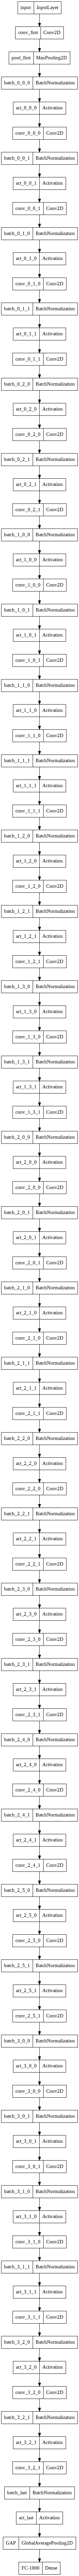

In [ ]:
keras.utils.plot_model(model_plain_34)

In [ ]:
model_plain_50 = build_plain(is_50=True)
model_plain_50.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv_first (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 pool_first (MaxPooling2D)   (None, 56, 56, 64)        0         
                                                                 
 batch_0_0_0 (BatchNormaliza  (None, 56, 56, 64)       256       
 tion)                                                           
                                                                 
 act_0_0_0 (Activation)      (None, 56, 56, 64)        0         
                                                                 
 conv_0_0_0 (Conv2D)         (None, 56, 56, 64)        4160      
                                                           

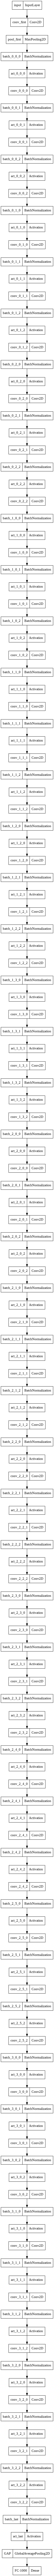

In [ ]:
keras.utils.plot_model(model_plain_50)

# 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

\# Ablation Study

In [ ]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True,
    data_dir='/content/drive/MyDrive/colab_data'
)

In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [ ]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


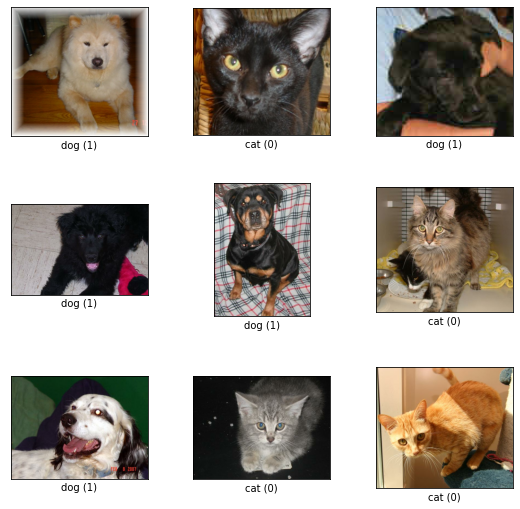

In [ ]:
fig = tfds.show_examples(ds_train, ds_info) # 예제 확인

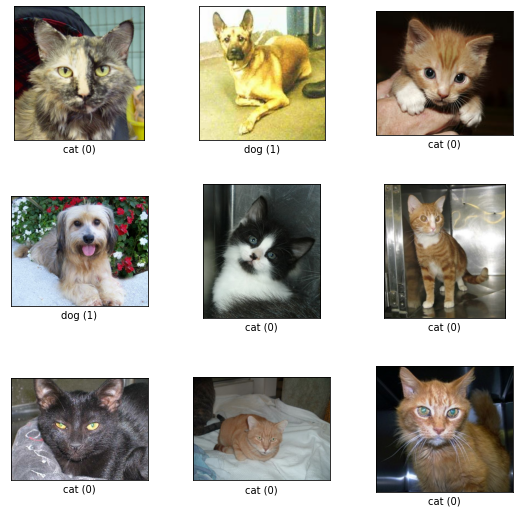

In [ ]:
fig = tfds.show_examples(ds_test, ds_info) # 예제 확인

In [ ]:
# 이미지를 리사이즈하고 픽셀값을 정규화합니다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [ ]:
# 이미지 리사이즈 및 픽셀값 정규화를 적용하고 배치 데이터로 만들어줍니다.
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

**\# ResNet-34 vs Plain-34**

In [ ]:
# catdog 데이터를 이용하기 위한 ReNet-34 빌딩
catdog_resnet_34 = build_resnet(catdog=True)
catdog_resnet_34.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_first (Conv2D)            (None, 112, 112, 64  9472        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 pool_first (MaxPooling2D)      (None, 56, 56, 64)   0           ['conv_first[0][0]']             
                                                                                            

In [ ]:
BATCH_SIZE = 16
EPOCH = 10

In [ ]:
# 위에서 정의한 함수를 이용해 데이터를 전처리합니다.
ds_a_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_a_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [ ]:
# 모델 컴파일
catdog_resnet_34.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

# 모델 학습
history_resnet_34 = catdog_resnet_34.fit(
    ds_a_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_a_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/10
1163/1163 [==============================] - 103s 74ms/step - loss: 0.6759 - accuracy: 0.5965 - val_loss: 0.7599 - val_accuracy: 0.5194
Epoch 2/10
1163/1163 [==============================] - 83s 72ms/step - loss: 0.6241 - accuracy: 0.6549 - val_loss: 0.7381 - val_accuracy: 0.5557
Epoch 3/10
1163/1163 [==============================] - 84s 72ms/step - loss: 0.5807 - accuracy: 0.6981 - val_loss: 0.6159 - val_accuracy: 0.6708
Epoch 4/10
1163/1163 [==============================] - 84s 72ms/step - loss: 0.5312 - accuracy: 0.7394 - val_loss: 1.5158 - val_accuracy: 0.5805
Epoch 5/10
1163/1163 [==============================] - 84s 72ms/step - loss: 0.4846 - accuracy: 0.7740 - val_loss: 0.5860 - val_accuracy: 0.7319
Epoch 6/10
1163/1163 [==============================] - 84s 72ms/step - loss: 0.4221 - accuracy: 0.8087 - val_loss: 0.4290 - val_accuracy: 0.8052
Epoch 7/10
1163/1163 [==============================] - 84s 72ms/step - loss: 0.3554 - accuracy: 0.8454 - val_loss: 0.3954 

In [ ]:
# catdog 데이터를 이용하기 위한 Plain-34 빌딩
catdog_plain_34 = build_plain(catdog=True)
catdog_plain_34.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv_first (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 pool_first (MaxPooling2D)   (None, 56, 56, 64)        0         
                                                                 
 batch_0_0_0 (BatchNormaliza  (None, 56, 56, 64)       256       
 tion)                                                           
                                                                 
 act_0_0_0 (Activation)      (None, 56, 56, 64)        0         
                                                                 
 conv_0_0_0 (Conv2D)         (None, 56, 56, 64)        36928     
                                                           

In [ ]:
catdog_plain_34.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

history_plain_34 = catdog_plain_34.fit(
    ds_a_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_a_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/10
1163/1163 [==============================] - 87s 69ms/step - loss: 0.7009 - accuracy: 0.5163 - val_loss: 0.7032 - val_accuracy: 0.4901
Epoch 2/10
1163/1163 [==============================] - 80s 68ms/step - loss: 0.6915 - accuracy: 0.5264 - val_loss: 0.8193 - val_accuracy: 0.4840
Epoch 3/10
1163/1163 [==============================] - 80s 68ms/step - loss: 0.6964 - accuracy: 0.5127 - val_loss: 0.6929 - val_accuracy: 0.5308
Epoch 4/10
1163/1163 [==============================] - 80s 69ms/step - loss: 0.6954 - accuracy: 0.5093 - val_loss: 1.4826 - val_accuracy: 0.5539
Epoch 5/10
1163/1163 [==============================] - 80s 68ms/step - loss: 0.6922 - accuracy: 0.5305 - val_loss: 0.7157 - val_accuracy: 0.5103
Epoch 6/10
1163/1163 [==============================] - 79s 68ms/step - loss: 0.6836 - accuracy: 0.5544 - val_loss: 0.7135 - val_accuracy: 0.5002
Epoch 7/10
1163/1163 [==============================] - 80s 68ms/step - loss: 0.6676 - accuracy: 0.5940 - val_loss: 0.7079 -

**\# ResNet-50 vs Plain-50**

In [ ]:
# # catdog 데이터를 이용하기 위한 ReNet-50 빌딩
catdog_resnet_50 = build_resnet(is_50=True, catdog=True)
catdog_resnet_50.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_first (Conv2D)            (None, 112, 112, 64  9472        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 pool_first (MaxPooling2D)      (None, 56, 56, 64)   0           ['conv_first[0][0]']             
                                                                                            

In [ ]:
catdog_resnet_50.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

history_resnet_50 = catdog_resnet_50.fit(
    ds_a_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_a_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/10
1163/1163 [==============================] - 141s 113ms/step - loss: 0.6644 - accuracy: 0.6116 - val_loss: 3.9562 - val_accuracy: 0.5153
Epoch 2/10
1163/1163 [==============================] - 130s 112ms/step - loss: 0.5896 - accuracy: 0.6876 - val_loss: 0.5850 - val_accuracy: 0.7060
Epoch 3/10
1163/1163 [==============================] - 130s 112ms/step - loss: 0.5248 - accuracy: 0.7443 - val_loss: 0.6033 - val_accuracy: 0.7190
Epoch 4/10
1163/1163 [==============================] - 130s 112ms/step - loss: 0.4575 - accuracy: 0.7853 - val_loss: 0.6481 - val_accuracy: 0.7066
Epoch 5/10
1163/1163 [==============================] - 130s 112ms/step - loss: 0.3969 - accuracy: 0.8228 - val_loss: 0.5799 - val_accuracy: 0.7174
Epoch 6/10
1163/1163 [==============================] - 130s 112ms/step - loss: 0.3416 - accuracy: 0.8526 - val_loss: 0.4078 - val_accuracy: 0.8184
Epoch 7/10
1163/1163 [==============================] - 131s 112ms/step - loss: 0.2986 - accuracy: 0.8730 - val_

In [ ]:
# # catdog 데이터를 이용하기 위한 Plain-50 빌딩
catdog_plain_50 = build_plain(is_50=True, catdog=True)
catdog_plain_50.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv_first (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 pool_first (MaxPooling2D)   (None, 56, 56, 64)        0         
                                                                 
 batch_0_0_0 (BatchNormaliza  (None, 56, 56, 64)       256       
 tion)                                                           
                                                                 
 act_0_0_0 (Activation)      (None, 56, 56, 64)        0         
                                                                 
 conv_0_0_0 (Conv2D)         (None, 56, 56, 64)        4160      
                                                           

In [ ]:
catdog_plain_50.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

history_plain_50 = catdog_plain_50.fit(
    ds_a_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_a_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/10
1163/1163 [==============================] - 120s 96ms/step - loss: 0.7089 - accuracy: 0.5091 - val_loss: 0.6937 - val_accuracy: 0.5365
Epoch 2/10
1163/1163 [==============================] - 111s 95ms/step - loss: 0.6969 - accuracy: 0.5124 - val_loss: 1.0465 - val_accuracy: 0.4696
Epoch 3/10
1163/1163 [==============================] - 110s 95ms/step - loss: 0.6973 - accuracy: 0.4982 - val_loss: 0.6952 - val_accuracy: 0.5041
Epoch 4/10
1163/1163 [==============================] - 111s 95ms/step - loss: 0.6947 - accuracy: 0.5157 - val_loss: 0.6919 - val_accuracy: 0.5427
Epoch 5/10
1163/1163 [==============================] - 111s 95ms/step - loss: 0.6953 - accuracy: 0.5093 - val_loss: 8.2853 - val_accuracy: 0.5095
Epoch 6/10
1163/1163 [==============================] - 111s 95ms/step - loss: 0.6974 - accuracy: 0.5065 - val_loss: 0.6924 - val_accuracy: 0.5250
Epoch 7/10
1163/1163 [==============================] - 111s 96ms/step - loss: 0.6924 - accuracy: 0.5183 - val_loss: 1

\# 시각화

ResNet-34와 Plain-34의 loss를 비교해봅니다.

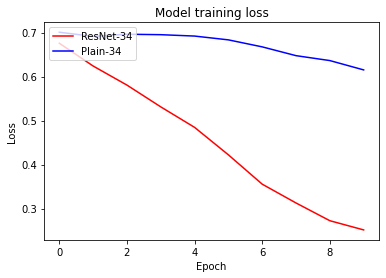

In [ ]:
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

10번의 EPOCH이지만 loss 감소가 눈에 띄게 달랐다.  
ResNet-34 모델은 우하향 하는 모습이 두드러졌고, Plain-34 모델은 loss가 0.7 근처에서 0.6 근처로 0.1 정도밖에 떨어지지 않았다.

ResNet-34와 Plain-34의 validation accuracy를 비교해봅니다.

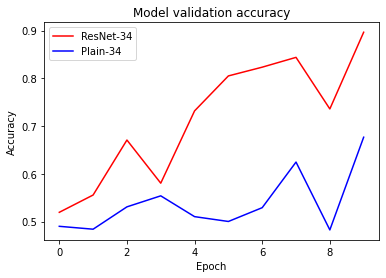

In [ ]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

validation accuracy에서도 성능차를 명확히 확인할 수 있다.  
ResNet-34는 최종적으로 89%의 정확도를 보인 반면, Plain-34는 67%에 그쳤다.  
처음부터 차이가 있었지만 진행될수록 그 차가 더 커진 모습이다.

이번에는 ResNet-50와 Plain-50의 loss를 비교해봅니다.

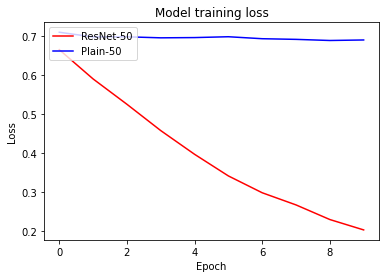

In [ ]:
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

34 레이어 모델에서보다 차이가 더 크게 나타난다.  
ResNet-50 모델은 loss가 큰 기울기를 보이며 계속 우하향하는 가운데, Plain-50은 거의 감소하지 않은 모습을 보여준다.

ResNet-50과 Plain-50의 validation accuracy를 비교해봅니다.

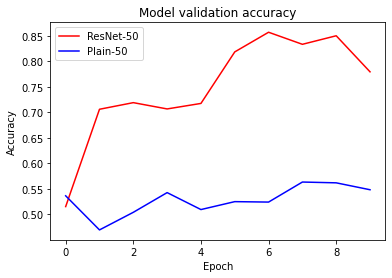

In [ ]:
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

가장 높았던 값을 기준으로,  
ResNet-50은 85%, Plain-50은 56%의 정확도를 보여준다.  
데이터셋이 크지 않으므로 34레이어 모델에 비해 정확도가 조금 낮아 보이지만 더 많은 EPOCH을 진행하면 개선 될 여지가 있다.  
가장 첫 EPOCH에서는 Plain-50 모델의 정확도가 조금 높았으나, loss가 거의 떨어지지 않으면서 정확도가 제자리를 벗어나지 못했다.

---

# 회고

* Skip connection 유무 차이뿐인데도 성능에서 큰 차이를 보였다.  
충분히 학습을 시켜준다면 더 큰 차이가 날 것이고, 데이터 크기가 늘어날수록 더 큰 차이를 보일것이다.
* ResNet을 직접 구현해보면서 많은 시행착오를 겪었다.  
블럭을 구성할 때 고려해야할 조건들이 많았으며, 어떤 조건들을 매개변수로 받아야하는지에 대한 고민이 많았다.  
이러한 조건들에 대해 충분히 정리를 하고 네트워크를 구성해야 원활할 것 같다.
* 사실 조건들 보다도, 네트워크를 처음부터 구성하려니 시작이 막막했다.  
함수 이름부터 정의를 하고, 필요한 레이어를 쓰고나니 그 다음부터는 시행착오가 많았지만 흥미로운 작업이 되었다.  
네트워크 자체를 연구하는 것도 재밌을 것 같다.